In [1]:
import re
import os
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt


# configure to ns-3.40 directory
os.chdir(r'/Users/user/Desktop/path-comparison/ns-3.40')

os.system("mkdir data")
os.system("./ns3 clean")
os.system("./ns3 configure")
os.system("./ns3 build")
print(os.getcwd())

In [2]:
# [MUST RUN] helper functions for parsing logs
class EventType(Enum):
    ENQUEUE = 1
    SEND_OR_DEQUEUE = 2
    RECEIVE = 3

def run_simple(delay, longDelay, initialCwnd, bytesToSend=1000, linkDelay=5, delaySerialization=0):
    os.system("rm -rf traces")
    os.system("mkdir traces")
    os.system("NS_LOG=\"TcpCongestionOps:TcpSocketBase\" ./ns3 run single-flow/single-flow.cc -- --delay={}ms --longDelay={}ms --bytesToSend={} --initialCwnd={} --delayAccess={}ms --delaySerialization={}ms  > traces/tcp_logs.txt 2>&1".format(
        str(delay), str(longDelay), str(bytesToSend), str(initialCwnd), str(linkDelay), str(delaySerialization)))

def get_span(matcher, txt):
    return txt[matcher.span()[0]:matcher.span()[1]]

def parse_info(line, link):
    event = None
    if line[0] == '+':
        event = EventType.ENQUEUE
    elif line[0] == '-':
        event = EventType.SEND_OR_DEQUEUE
    elif line[0] == 'r':
        event = EventType.RECEIVE


    time = float(line[1:].split()[0])
    length_matcher = re.search("(size=\d*)", line)
    if length_matcher is None:
        length = 0
    else:
        length = int(line[length_matcher.span()[0]+5:length_matcher.span()[1]])
    src_dest_matcher = re.search("\d*\.\d*\.\d*\.\d*\s[\>\<]\s\d*\.\d*\.\d*\.\d", line)
    src_dest_str = get_span(src_dest_matcher, line)
    seq_matcher = re.search("Seq=\d*", line)
    seq_no = int(line[seq_matcher.span()[0]+4:seq_matcher.span()[1]])
    ack_matcher = re.search("Ack=\d*", line)
    ack_no = int(line[ack_matcher.span()[0]+4:ack_matcher.span()[1]])
    
    return {"link": link,
            "event": event, 
            "time": time, 
            "len":length,
            "src_dest":src_dest_str,
            "seq":seq_no,
            "ack":ack_no}

def parse_link(host_node, int1, int2, events):
    f = open("traces/-"+host_node+"-Int"+int1+"->"+int2+".tr", "r")
    while True:
        line = f.readline()
        if len(line) == 0:
            break

        info = parse_info(line, str(int1)+"->"+str(int2))
        events.append(info)


In [3]:
# [MUST RUN] helper functions for printing

def event_str(event):
    if event == EventType.ENQUEUE:
        return "Enqueue"
    elif event == EventType.SEND_OR_DEQUEUE:
        return "SEND"
    elif event == EventType.RECEIVE:
        return "RCV"
    else:
        return "ERROR"
    
def print_rtx(out):
    f = open("traces/-Client-IntCl->R1.tr", "r")

    current_max = 0
    rtxs = []

    while True:
        line = f.readline()
        if len(line) == 0:
            break

        info_dict = parse_info(line, "Cl->R1")
        if info_dict["event"] == EventType.SEND_OR_DEQUEUE:
            seq_no = info_dict["seq"]
            length = info_dict["len"]
            if seq_no < current_max:
                rtxs.append((seq_no, length))
            current_max = max(current_max, seq_no)

    out.write("RTX SEQ NOs: " + str([i for (i, j) in rtxs]))
    out.write("TOTAL RTX LEN: " + str(sum([j for (i, j) in rtxs])))

def print_info(info_dict, out):
    out.write("{:.6f} {} {} \nSeq: {} Ack: {} Payload: {}\n===================================\n".format(
        info_dict["time"], 
        event_str(info_dict["event"]), 
        info_dict["link"], 
        info_dict["seq"],
        info_dict["ack"],
        info_dict["len"]
    ))


def print_fork_sends():
    events = []
    parse_link("Client", "Cl", "R1", events)
    # parse_link("Router1", "R1", "R3", events)
    # parse_link("Router1", "R1", "R4", events)
    # parse_link("Server", "Se", "R2", events)

    sorted_events = sorted(events, key=lambda x: x["time"])

    f = open('traces/clr1.txt', 'w')

    for s_e in sorted_events:
        if s_e["event"] != EventType.ENQUEUE:
            print_info(s_e, f)

    print_rtx(f)
    f.close()


In [4]:
# [MUST RUN] - detect fast rtx, get p
def detect_fast_rtx():
    # given a run_simple, attempts to detect fast rtx via tcp_logs
    f = open('traces/tcp_logs.txt', 'r')

    while True:
        line = f.readline()
        if len(line) == 0:
            f.close()
            return False

        if "TcpSocketBase:DoRetransmit()" in line:
            f.close()
            return True
        
def get_p():
    # calculate the time between packets
    events = []
    parse_link("Client", "Cl", "R1", events)

    sorted_events = sorted(events, key=lambda x: x["time"])

    f = open('traces/clr1.txt', 'w')

    p_packet = False

    for s_e in sorted_events:
        if p_packet:
            f.close()
            return s_e["time"] - p_start
        if s_e["event"] != EventType.ENQUEUE and s_e["len"] == 512:
            p_start = s_e["time"]
            p_packet = True

    f.close()
    return None

In [13]:
scatter_true = []
scatter_false = []

plot_range = np.arange(0.5, 20, .5)

for i in plot_range:
    for j in plot_range:
        run_simple(i, j, 10, bytesToSend=5000, linkDelay=1, delaySerialization=0)
        p = get_p()
            
        if detect_fast_rtx():
            scatter_true.append((i, j))
        else:
            scatter_false.append((i, j))


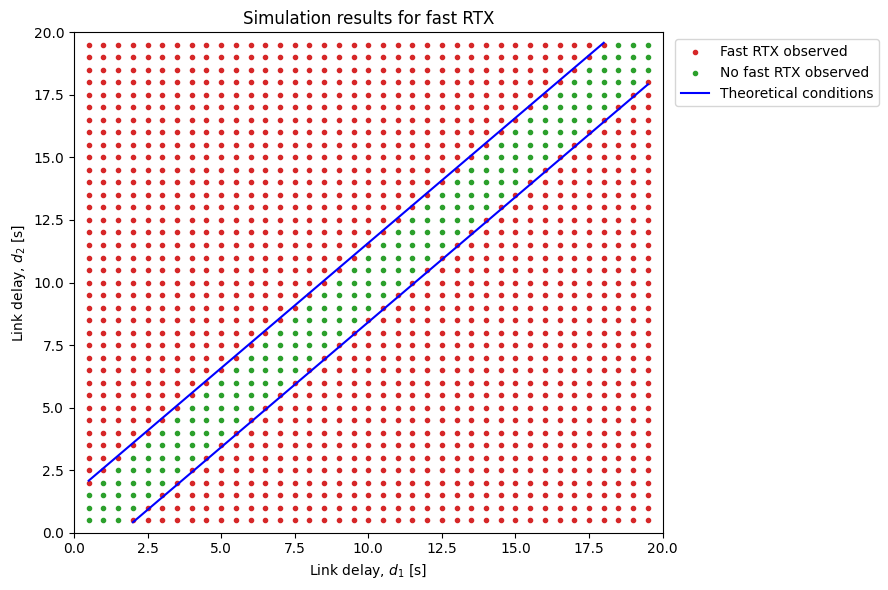

In [38]:

plt.figure(figsize=(9, 6))

plt.title("Simulation results for fast RTX")
plt.xlabel("Link delay, $d_1$ [ms]")
plt.xlim(left=0, right=20)
plt.ylabel("Link delay, $d_2$ [ms]")

plt.ylim(bottom=0, top=20)
plt.scatter([i for (i, j) in scatter_true], [j for (i, j) in scatter_true], c='tab:red', marker='.', label='Fast RTX observed')
plt.scatter([i for (i, j) in scatter_false], [j for (i, j) in scatter_false], c='tab:green', marker='.', label='No fast RTX observed')
if p is not None:
    # plot line of delay and 7*p
    upper_plot_range = np.arange(.5, 18.5, .5)
    lower_plot_range = np.arange(2., 20, .5)

    plt.plot(upper_plot_range, [i + 7000*p for i in upper_plot_range], c='blue', label='Theoretical conditions')
    plt.plot(lower_plot_range, [i - 7000*p for i in lower_plot_range], c='blue')

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.tight_layout()